# Depletion Measurement and Hitrates
This program is designed to study hit rates in diffrent bins of a histogram. Looking mainly at the hitrates across pixels.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm 
from scipy import optimize
import matplotlib.pyplot as plt
from astropy import units as un
import regex as re
import h5py
import os
%config InlineBackend.figure_format = 'retina'


In [2]:

def processDigital(a):
    """
    Implementation of Henrike's digital processing and hit pairing algorithym? algorythim? How is this spelled?. This only works for single pixel
    returns: 
    (df, [counts_pre, counts_post])
    """
    len1 = len(a)
    a = a[(((a.payload == ' 4') | (a.payload == 4)) & ((a["Chip ID"] == 0) | (a["Chip ID"] == '0')))]
    len2 =len(a)
    group = a.groupby(["readout", "timestamp"])
    b = a.set_index(["readout", "timestamp"])
    counts = group.count().payload
    counts = counts[counts==2]
    i = counts.index
    b = b.loc[i]
    col = b[b["isCol"] == True]
    row = b[b["isCol"] == False]
    return (b, [len1, len1-len2, len2])

In [3]:
# This is the gaussian I am using to fit all of my curves 

def gauss(x, a, mean, sig, bg):
    return a * norm.pdf(x, mean, sig) + bg

In [4]:
def fitCurve(hist:np.ndarray, bins:np.ndarray, time:float, imgpath:str, bias, rate, plot = True):
    histTest = hist/time
    #print(sum(histTest))
    
    sig = (np.sqrt(hist)/time)
    # Scipy magic (tm)
    coef, pcov = optimize.curve_fit(gauss, bins, histTest, sigma=sig, absolute_sigma=True, p0=(sum(hist), 1, 1, hist.min()), bounds=(0, [np.inf, np.inf, np.inf, hist.min()*2]))
    if plot:
        # All of the plotting stuffs 
        fig, ax = plt.subplots()
        fig.set_dpi(150)
        fig.set_size_inches((6, 4))
        if rate:
            ax.set_title("Digital ToT Ratehistogram\nBa133 6hr run " + str(bias) + "V bias")
            ax.set_ylabel("Counts per Minute")
        else:
            ax.set_title("Digital ToT Histogram\nBa133 6hr run " + str(bias) + "V bias")
            ax.set_ylabel("Counts")
        ax.set_xlabel("ToT(us)")
        ax.bar(bins, (histTest), color = 'blue')
        ax.plot(bins, gauss(bins, *coef), color='red')
        ax.grid()
        fig.savefig(imgpath, dpi=200, facecolor='white')
        plt.close() # Doesn't display all the plots
    
    perr = np.sqrt(np.diag(pcov))
    return ([*coef], [*perr])

## Main Loop
This loop reads in all of the CSVs, fits curves, and writes out the graphs and info CSVs.

Infoframe writes out the following information: 
- File 
- Bias
- totalCounts
- badCounts
- goodCounts
- rowcounts
- ToTpeak [Highest ToT peak]
- peakCounts [Counts in ToTpeak bin]
- a [Normalisation parameter of gaussian, area of gaussian]
- avar [uncertianty of A]
- mean [mean of gaussian]
- meanVar [Uncertianty of mean of gaussian]
- stdiv [std of gaussian]
- stdVar [Uncertianty of standard deviation of gaussian]
- bg [Background of gaussian]
- bgVar [uncertianty of bg parameter]



In [5]:
# This loops through a directory of CSVs from ditital data, fits a gaussian, and loggs all of the data about it 

imgdir = "./sourceScan/figs/totals" # Where to store images
datadir = "./sourceScan/" # Where data is stored 
infopath = "./statsPerFile.csv" # Where to save the total count info
infopath_rates = "./rateStatsPerFile.csv" # Where to save the rate info
extrapath = "ba133_6hrRun_NEW" # used in saving images 
maintitle = "Ba133 6hr Voltage Scan - Row data" # Suptitle to put on ToT spectra

nbins = 40 # Bins used in the binning 
runtime = 6 * 60 # Runtime in minutes 

# This is the header of the dataframe which stores the  info
infoframe = pd.DataFrame(columns=["file", "bias", "totalCounts", 'badCounts', 'goodCounts', 'rowcounts', 'ToTpeak', 'peakCounts', 'a', 'avar', "mean", 'meanVar', "stdiv", 'stdVar', 'bg', 'bgVar'])
# all of the raw data (after processing 
datas = {}
for path in os.listdir(datadir):
    if os.path.isdir(path): continue
    elif path.rfind(".csv") == -1: continue
    else:
        bias = float(re.search("_-(\d+?)V", path).group(1))
        df = pd.read_csv(datadir+path)
        df, counts = processDigital(df)
        datas[bias] = df
        datas[bias]["bias"] = bias
        binsize = (df.tot_us.max()-df.tot_us.min())/nbins
        hist, bins = np.histogram(df[df.isCol == False].tot_us, bins = nbins)
        bincenter = (bins + (binsize/2))[0:-1]
        coefs, perr = fitCurve(hist, bincenter, 1, f"{imgdir}/{extrapath}{bias}Vbias.png", bias, False)
        dats = [path, bias, counts[0], counts[1], counts[2], len(df[df.isCol == False]) ,bincenter[hist == hist.max()].max(), hist.max(), coefs[0], perr[0], coefs[1], perr[1], coefs[2], perr[2], coefs[3], perr[3]]
        infoframe.loc[len(infoframe)] = dats
        
infoframe = infoframe.sort_values(by="bias", axis=0, ascending=True).reset_index()
infoframe.to_csv(infopath)
                               

In [6]:
infoframe.rowcounts.mean()

3416.076923076923

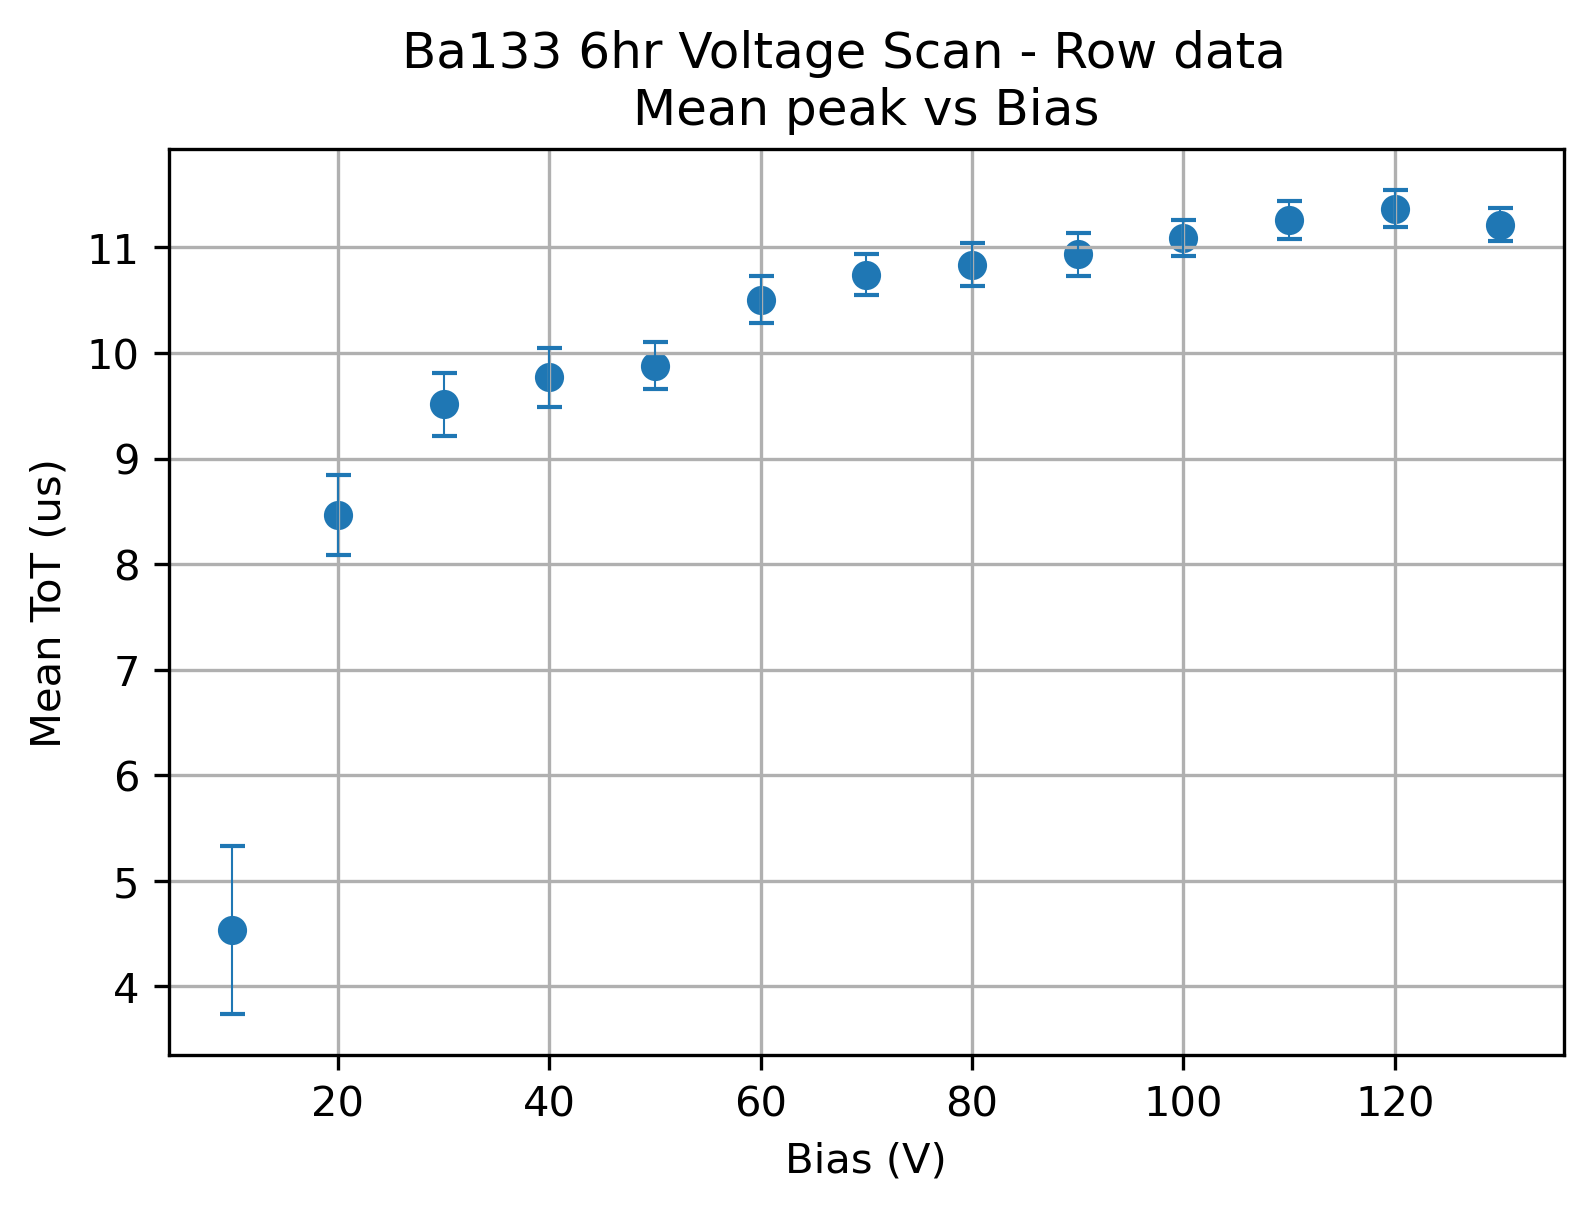

In [7]:
fig, ax = plt.subplots()

fig.set_dpi(150)
fig.suptitle(maintitle)
ax.set_title("Mean peak vs Bias")
ax.set_ylabel("Mean ToT (us)")
ax.set_xlabel("Bias (V)")
ax.errorbar(infoframe.bias, infoframe["mean"], yerr=infoframe.meanVar, fmt='none', capsize=3, linewidth = .5)
ax.scatter(infoframe.bias, infoframe["mean"])
ax.grid()
fig.savefig(imgdir+"/"+extrapath+"AmeanVbias.png", facecolor="white", dpi=600)

## Hitrates and those calculations 
This cell goes and calculates the hit rates and fits the histogram to them and also makes more graphs
rateinfoframe writes out the following information: 
- File 
- Bias
- totalRate [Total hits/runtime]
- rateVar [$\sqrt{counts}/runtime$]
- ToTpeak [Highest ToT peak]
- peakCounts [Counts in ToTpeak bin]
- a [Normalisation parameter of gaussian, area of gaussian]
- avar [uncertianty of A]
- mean [mean of gaussian]
- meanVar [Uncertianty of mean of gaussian]
- stdiv [std of gaussian]
- stdVar [Uncertianty of standard deviation of gaussian]
- bg [Background of gaussian]
- bgVar [uncertianty of bg parameter]


In [8]:
# Plots and saves the hitrates and data
imgdir = "./sourceScan/figs/rates"
datadir = "./sourceScan/"
infopath = "./statsPerFile.csv"
infopath_rates = "./rateStatsPerFile.csv"
extrapath = "ba133_6hrRun_Rates"
maintitle = "Ba133 6hr Voltage Scan - Row Rates"

rateinfoframe = pd.DataFrame(columns=["file", "bias", "totalRate", 'rateVar', 'ToTpeak', 'peakCounts', 'a', 'avar', "mean", 'meanVar', "stdiv", 'stdVar', 'bg', 'bgVar'])

for df in datas.values(): 
    hist, bins = np.histogram(df[df.isCol == False].tot_us, bins = nbins)
    bincenter = (bins + (binsize/2))[0:-1]
    coefs, perr = fitCurve(hist, bincenter, runtime, f"{imgdir}/{extrapath}{df.bias.max()}Vbias.png", df["bias"].max(), True)
    dats = [path, df["bias"].max(), sum(hist)/runtime, (np.sqrt(len(df))/runtime),bincenter[hist == hist.max()].max(), hist.max(), coefs[0], perr[0], coefs[1], perr[1], coefs[2], perr[2], coefs[3], perr[3]]
    rateinfoframe.loc[len(rateinfoframe)] = dats
    
rateinfoframe = rateinfoframe.sort_values(by="bias", axis=0, ascending=True).reset_index()
rateinfoframe.to_csv(infopath_rates)

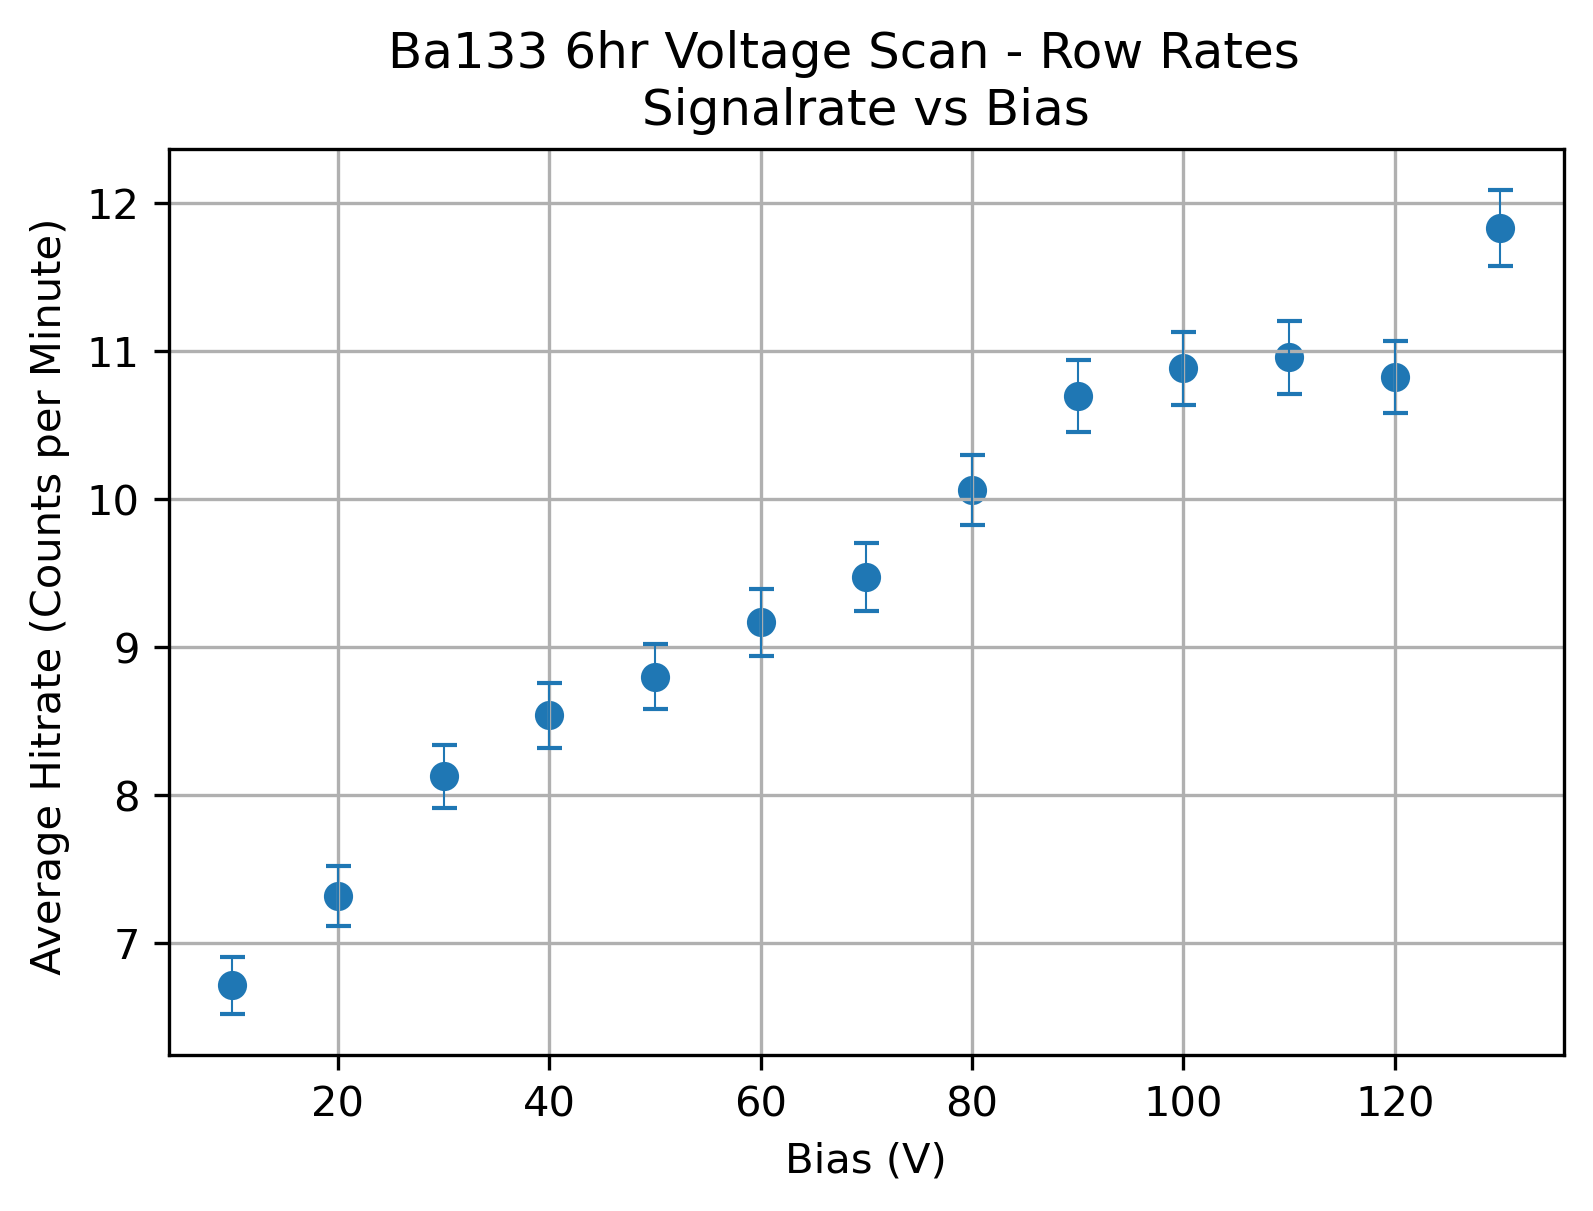

In [9]:
fig, ax = plt.subplots()

fig.set_dpi(150)
fig.suptitle(maintitle)
ax.set_title("Signalrate vs Bias")
ax.set_ylabel(" Average Hitrate (Counts per Minute)")
ax.set_xlabel("Bias (V)")
ax.errorbar(rateinfoframe.bias, rateinfoframe["totalRate"], rateinfoframe["rateVar"], fmt='none', capsize=3, linewidth = .5)
ax.scatter(rateinfoframe.bias, rateinfoframe["totalRate"])
ax.grid()
fig.savefig(imgdir+"/"+extrapath+"ratesVbias.png", facecolor="white", dpi=600)

## Signal vs Background
This compares the rates calculated from area of gaussian plus area of background of gaussian and the actual average rates we saw

sig is a dataframe which stores all of this information.

del_calc is the percent diffrence between the calculated average rate and the actual average rate

In [10]:
# This will attempt to calculate the background rates of signal
sig = rateinfoframe[["totalRate", "bg", 'bias', "a", "stdiv", "stdVar", 'avar', 'bgVar']].copy()
# bg returned by the curve fit gives the background *per bin* so to get an overall 
# background I multiply it by the number of bins
sig.bg = sig.bg*nbins
sig["calc_sig"] = sig.a
sig["calc_ttl"] = sig.bg + sig.calc_sig
sig["del_calc"] = ((sig.calc_ttl - sig.totalRate)/sig.totalRate) *100
sig["uncertian"] = sig.del_calc*(np.sqrt((sig.avar/sig.a)**2 + (sig.bgVar/sig.bg)**2))
sig["up"] = sig.uncertian/sig.del_calc
# Del cacl is  percentage!
print(sig[["bias", "bg", "calc_sig", "totalRate", "calc_ttl", "del_calc", "uncertian"]])
#print(rateinfoframe[["totalRate", "bg", 'bgVar', 'a', 'avar', 'stdiv', 'stdVar', 'mean', 'meanVar']])

     bias        bg  calc_sig  totalRate   calc_ttl  del_calc  uncertian
0    10.0  5.196507  1.793137   6.711111   6.989645  4.150338   0.588550
1    20.0  4.858655  2.538218   7.316667   7.396874  1.096222   0.084212
2    30.0  5.571954  2.580308   8.125000   8.152262  0.335534   0.023287
3    40.0  5.792320  2.745559   8.536111   8.537878  0.020704   0.001358
4    50.0  5.908294  2.834094   8.797222   8.742388 -0.623312  -0.036104
5    60.0  5.623120  3.616063   9.163889   9.239183  0.821643   0.042714
6    70.0  5.932256  3.522325   9.469444   9.454581 -0.156957  -0.007831
7    80.0  5.994194  4.036355  10.061111  10.030548 -0.303770  -0.014482
8    90.0  6.563226  4.143310  10.691667  10.706536  0.139071   0.006744
9   100.0  6.710652  4.117520  10.880556  10.828172 -0.481441  -0.021370
10  110.0  6.252972  4.725111  10.955556  10.978083  0.205628   0.008793
11  120.0  6.371818  4.408408  10.822222  10.780226 -0.388054  -0.016841
12  130.0  6.502720  5.315861  11.827778  11.818582

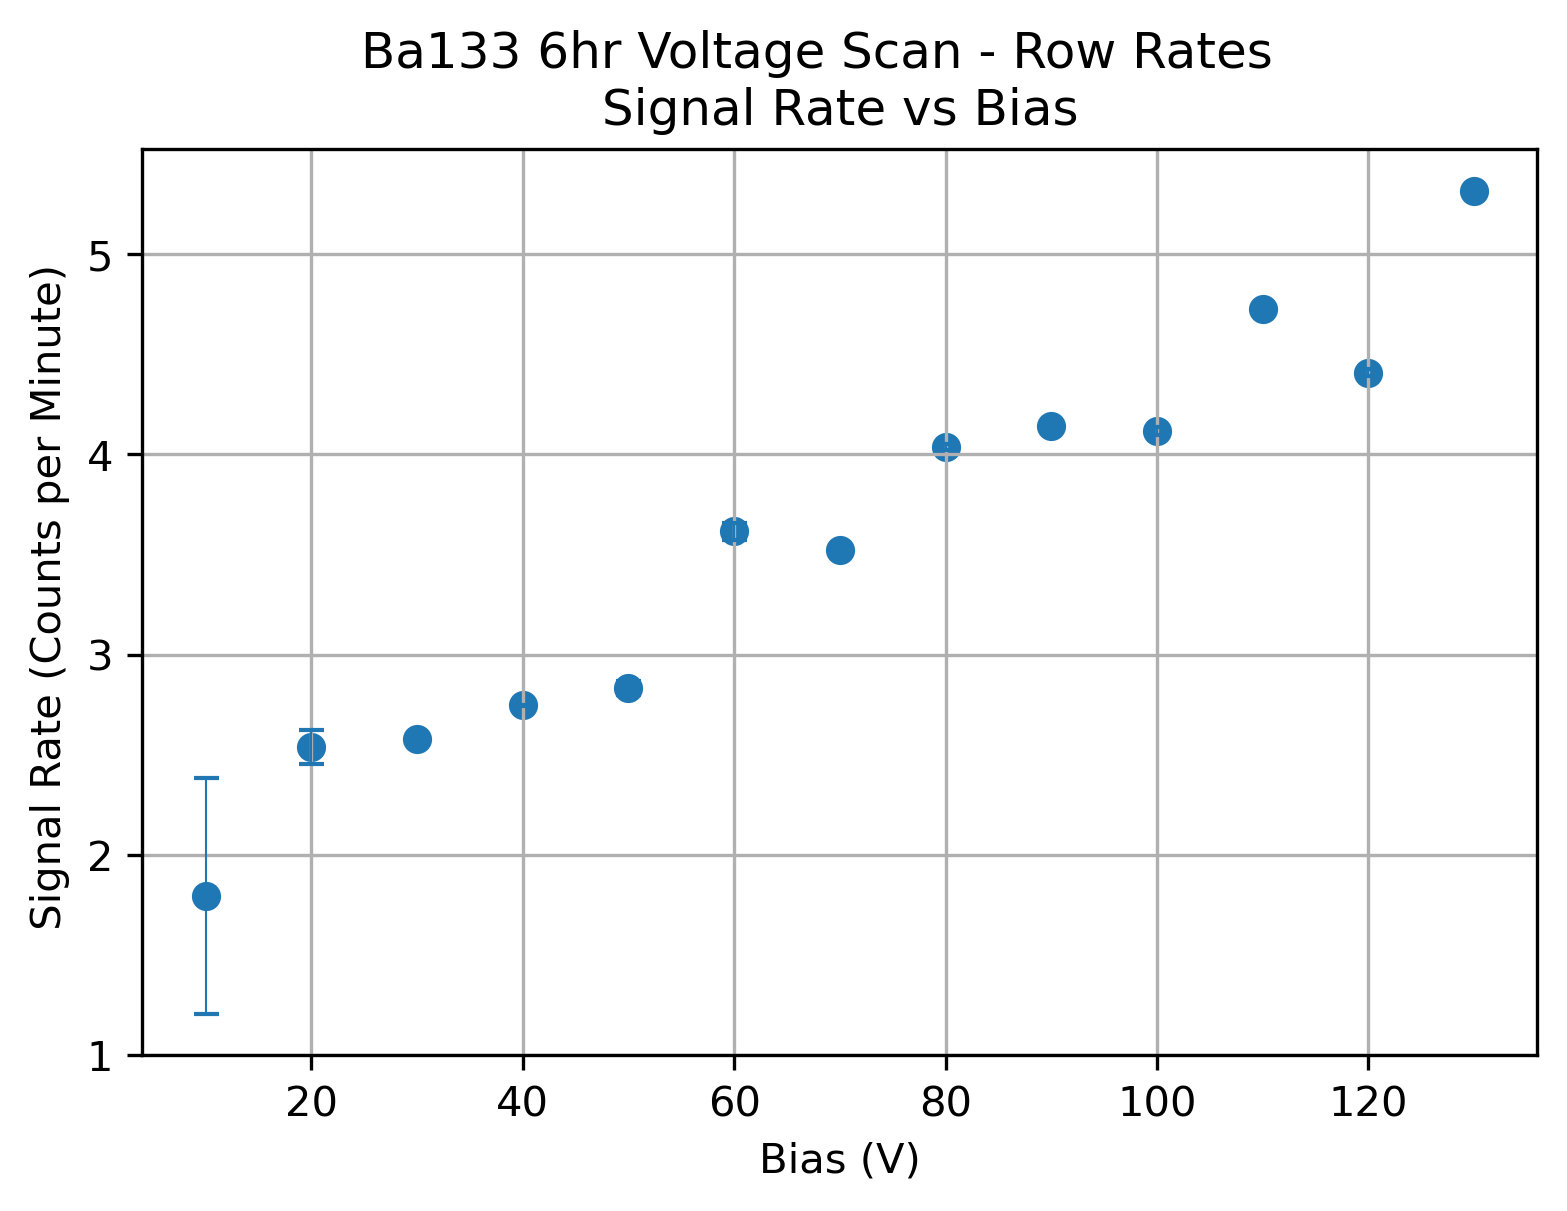

In [11]:
# Plots signal rates over time
fig, ax = plt.subplots()
fig.set_dpi(150)
fig.suptitle(maintitle)
ax.set_title("Signal Rate vs Bias")
ax.set_ylabel(" Signal Rate (Counts per Minute)")
ax.set_xlabel("Bias (V)")
ax.errorbar(sig.bias, sig.calc_sig, sig.uncertian, fmt='none', capsize=3, linewidth = .5)
ax.scatter(sig.bias, sig["calc_sig"])
ax.grid()
fig.savefig(imgdir+"/"+extrapath+"sigVbias.png", facecolor="white", dpi=600)

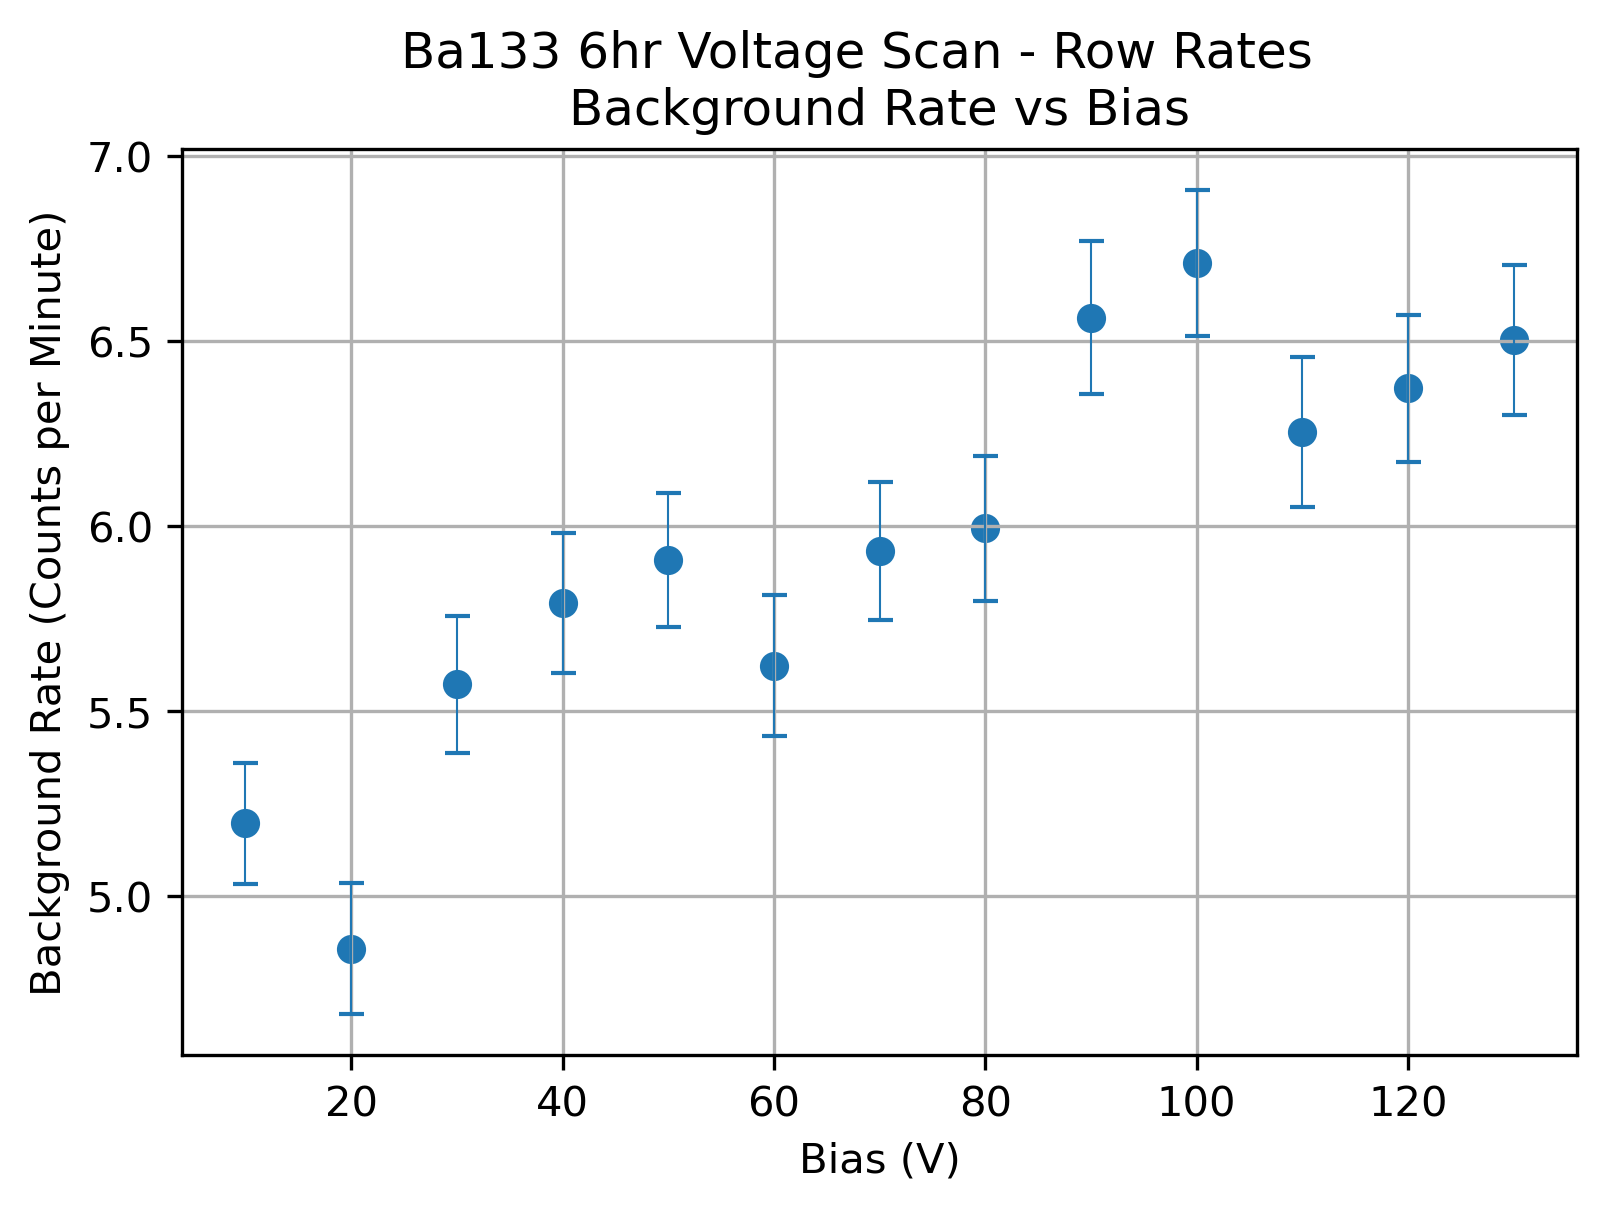

In [12]:
# Plots noise rates over time
fig, ax = plt.subplots()
fig.set_dpi(150)
fig.suptitle(maintitle)
ax.set_title("Background Rate vs Bias")
ax.set_ylabel("Background Rate (Counts per Minute)")
ax.set_xlabel("Bias (V)")
ax.errorbar(sig.bias, sig.bg, sig.bgVar*nbins, fmt='none', capsize=3, linewidth = .5)
ax.scatter(sig.bias, sig.bg)
ax.grid()
fig.savefig(imgdir+"/"+extrapath+"bgVbias.png", facecolor="white", dpi=600)

## Depletion depth calculation 
Here is where depletion depth is calculated. We have the `getTheoDepth()` which is the formula for a pn junction's depletion as a function of reverse bias and resistivity of the substrate; `getFlux()` which takes radius, pixel size, activity, and time (`m` or `s`, flux per minute or second). 

In [13]:
def getTheoDepth(del_v, res):
    del_v = del_v
    e = 1.04e-12 # Permitivity of Si, in cm
    u = 1.5e3 # mobility of electrons, in cm
    v0 = .6 # Built in potential
    return (np.sqrt(e*u*res*(del_v-v0)))*1e4 # 1e4 converts to um

In [14]:
# Calculates the flux from the source
def getFlux(r, pitch, A0, time):
    # In seconds
    if time == 's':
        return A0*((pitch**2)/(4*np.pi*(r**2))), 
    elif time == 'm': # in minutes 
        return (A0*((pitch**2)/(4*np.pi*(r**2))))*60 * un.s/un.min

In [15]:
# Set all units here
activity_Ci = 8.01 *1e-6 * un.Ci   # Activity in Ci
distance = 12452 * un.um    # center to center distance from source in um
pixel_pitch = 250 * un.um   # pixel pitch (um)
width = 5 * un.mm # distance from center to edge of sensor

R_30 = .962         # 30KeV photons per decay
R_36 = .2269        # 36KeV photons per decay

cs_30 = 51.4 * (un.barn)  # Cross section at 30KeV barns/atom
cs_36 = 30.5 * (un.barn) # Cross section at 36KeV barns/atom

si_density = 4.996e10 / un.um**3# Atoms per um**3

# Unit conversions 
# Converts from curies to events per second (bq) which is the same as Hz
activity = activity_Ci.to(un.Hz)

# Goes from barns to um**2
cs_30 = cs_30.to(un.um**2)
cs_36 = cs_36.to(un.um**2)


# Uncertianties
# Setting a 10% uncertianty on activity
u_act = .1 * activity
u_dst = 500 * un.um# Setting a 500um uncertianty 

# This calculates the amount of decays per minute  that will reach the pixel 
pix_flux = getFlux(distance, pixel_pitch, activity, 'm')
# This calculates the depth 
depth = rateinfoframe.a/(pix_flux*(R_30*cs_30 + R_36*cs_36)*si_density)


In [16]:
# Uncertianty propagation 
df = rateinfoframe

u_a = df.avar/df.a # absolute to fractional 

u_d = 2*(u_dst)/distance # 1. Abs to fractional, 2. squared in the getFlux() so we double it 

df2 = pd.DataFrame({'bias': df.bias, 'u_a':u_a, 'u_dst':u_d, 'u_act':u_act})


# These are all the units which do not have an uncertianty (that we are considering 
c = 1/((R_30*cs_30 + R_36*cs_36)*si_density)

df2["u_total_p"] = np.sqrt((u_a)**2 + (u_act)**2 + (2*u_d)**2) *100
print(df2)
depletion = pd.DataFrame({'bias':df2.bias, 'depth(um)':depth, 'uncertianty_p':df2.u_total_p, 'uncertianty':(df2.u_total_p/100 * depth)})

     bias       u_a     u_dst    u_act     u_total_p
0    10.0  0.141806  0.080308  29637.0  2.963700e+06
1    20.0  0.076815  0.080308  29637.0  2.963700e+06
2    30.0  0.069397  0.080308  29637.0  2.963700e+06
3    40.0  0.065595  0.080308  29637.0  2.963700e+06
4    50.0  0.057918  0.080308  29637.0  2.963700e+06
5    60.0  0.051980  0.080308  29637.0  2.963700e+06
6    70.0  0.049885  0.080308  29637.0  2.963700e+06
7    80.0  0.047668  0.080308  29637.0  2.963700e+06
8    90.0  0.048486  0.080308  29637.0  2.963700e+06
9   100.0  0.044381  0.080308  29637.0  2.963700e+06
10  110.0  0.042754  0.080308  29637.0  2.963700e+06
11  120.0  0.043393  0.080308  29637.0  2.963700e+06
12  130.0  0.038452  0.080308  29637.0  2.963700e+06


# Comparison with models

This section here graphs the models of depletion vs our measured depletion, as well as Yusuke's measures of depletion that Amanda found

/var/folders/v7/18hlpwzx76sfzhkz2t3zlkmm0000gp/T/ipykernel_2749/1929406969.py:6: RuntimeWarning: invalid value encountered in sqrt
  return (np.sqrt(e*u*res*(del_v-v0)))*1e4 # 1e4 converts to um
/var/folders/v7/18hlpwzx76sfzhkz2t3zlkmm0000gp/T/ipykernel_2749/1929406969.py:6: RuntimeWarning: invalid value encountered in sqrt
  return (np.sqrt(e*u*res*(del_v-v0)))*1e4 # 1e4 converts to um
/var/folders/v7/18hlpwzx76sfzhkz2t3zlkmm0000gp/T/ipykernel_2749/1929406969.py:6: RuntimeWarning: invalid value encountered in sqrt
  return (np.sqrt(e*u*res*(del_v-v0)))*1e4 # 1e4 converts to um


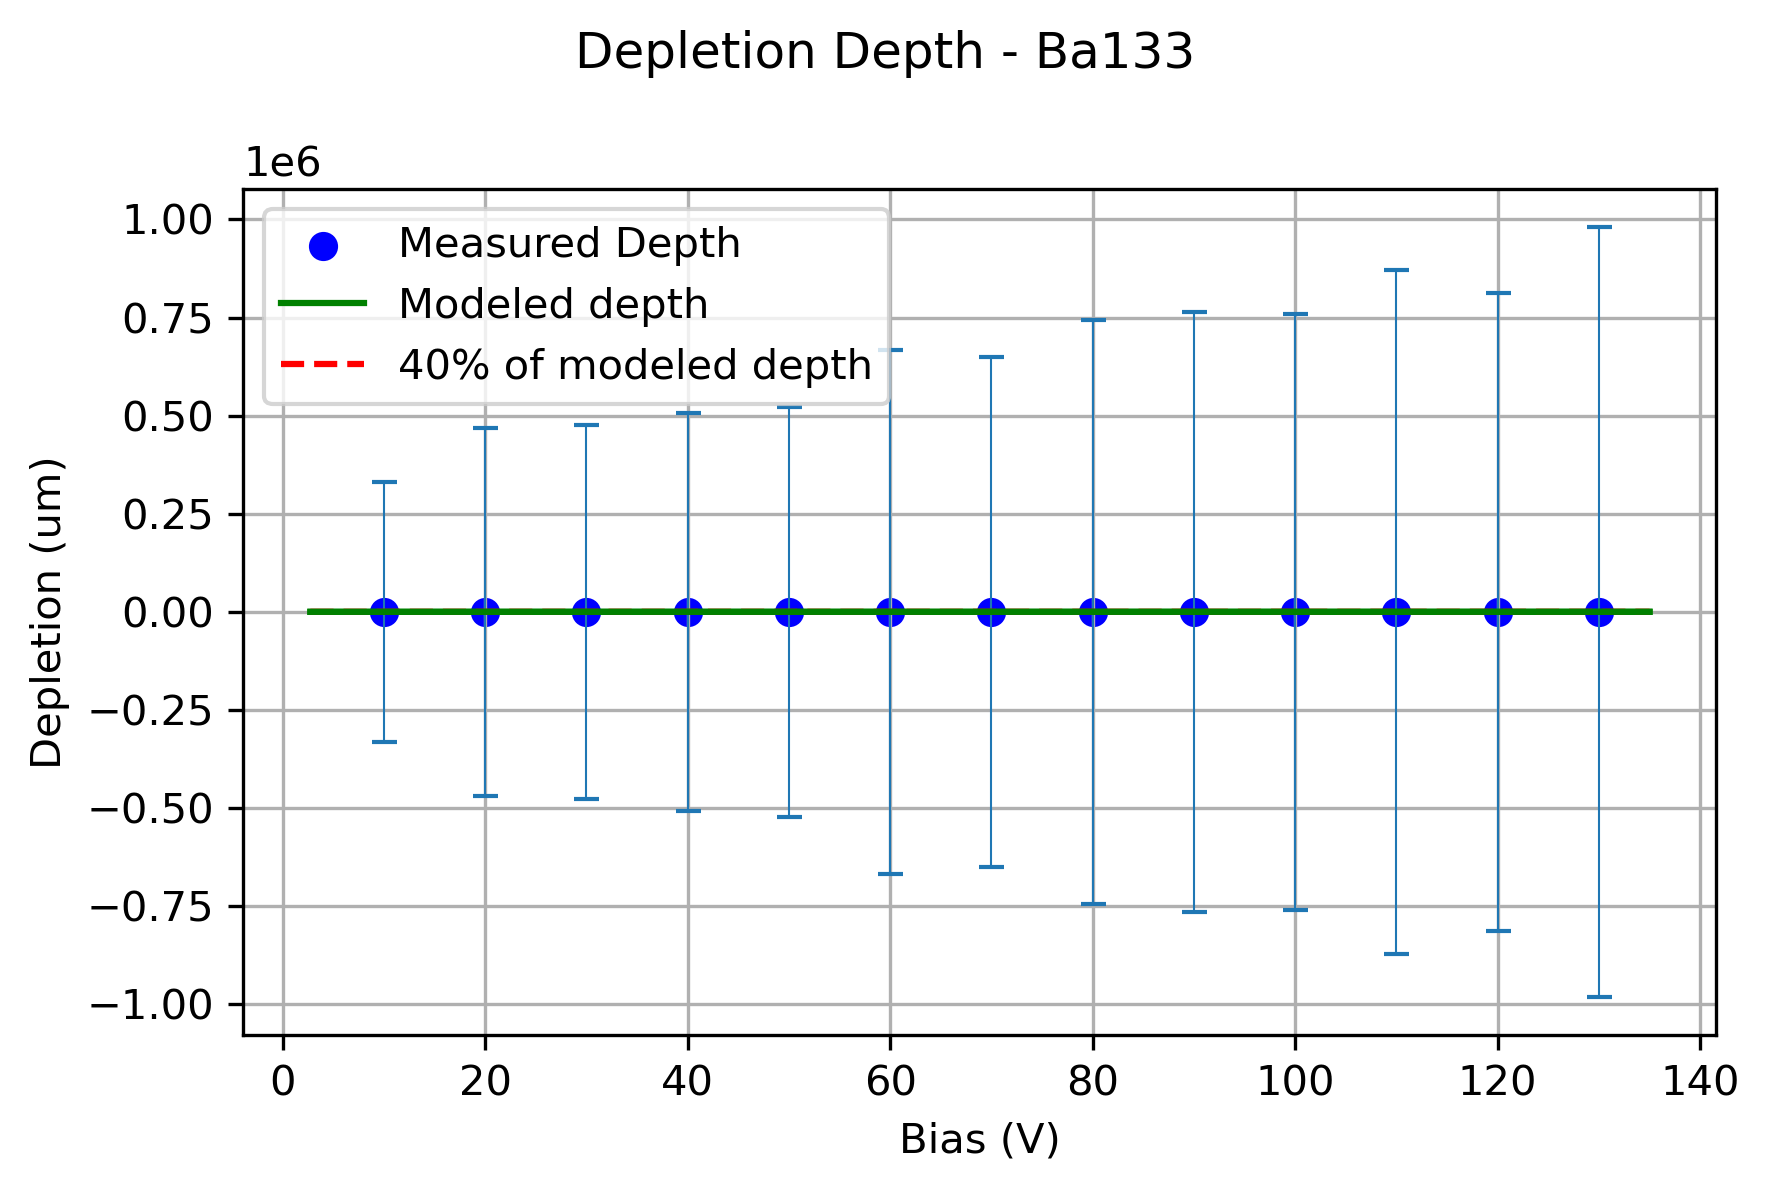

In [17]:
model = np.genfromtxt("megarun/modeledDepletion_yusuke.csv", skip_header=1, delimiter=',')
ydat = np.genfromtxt("megarun/measuredDepletion_yusuke.csv", skip_header=1, delimiter=',')

model = model[model[:,0]<135]
x = np.linspace(10,135,200)

#fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios': [2, 1]})
fig, ax= plt.subplots()

fig.tight_layout()
fig.set_size_inches((6,4))

fig.suptitle("Depletion Depth - Ba133")
fig.set_dpi(150)

x = np.linspace(0,135, 50)

ax.errorbar(depletion.bias, depletion['depth(um)'], yerr=depletion.uncertianty, capsize=3, linewidth = .5, fmt='none')
ax.scatter(depletion.bias, depletion['depth(um)'], color = 'blue', label="Measured Depth")

ax.plot(x, getTheoDepth(x, 300), label="Modeled depth", color='green')
ax.plot(x, .4*getTheoDepth(x, 300), label="40% of modeled depth", color='red', ls='--')

ax.plot(x, getTheoDepth(x, 200), color='green')
ax.legend()
# This plots Yusuke's depletion on top of the other measures 
#ax.errorbar(depletion.bias, depletion['depth(um)'], yerr=depletion.uncertianty, capsize=3, linewidth = .5, fmt='none')
#ax.plot(ydat[:,0], ydat[:,1], label='Yusuke Depletion')

ax.grid()
ax.set_xlabel("Bias (V)")
ax.set_ylabel("Depletion (um)")
fig.tight_layout()

#fig.legend()
fig.tight_layout()



fig.savefig(imgdir+"/"+extrapath+"depthVbiasWmodel.png", facecolor='white', dpi=600)

In [18]:
# This cell calculates the % diffrence from the modeled depth 
res = 300 # Resistivity of wafers
del_dp = ((getTheoDepth(depletion.bias, res) - depletion['depth(um)'])/getTheoDepth(depletion.bias, res))*100
depletion['model'] = getTheoDepth(depletion.bias, res)
depletion['per_from_model'] = del_dp
depletion[['bias', 'model', 'depth(um)', 'per_from_model']]

,bias,model,depth(um),per_from_model
0,10.0,20.974270,11.163153,46.776918
1,20.0,30.131711,15.801643,47.558096
2,30.0,37.093396,16.063674,56.693979
3,40.0,42.940890,17.092438,60.195426
4,50.0,48.082429,17.643615,63.305483
5,60.0,52.724947,22.511752,57.303415
6,70.0,56.990526,21.928188,61.523099
7,80.0,60.958346,25.128273,58.777961
8,90.0,64.683228,25.794121,60.122398
9,100.0,68.204985,25.633566,62.416873


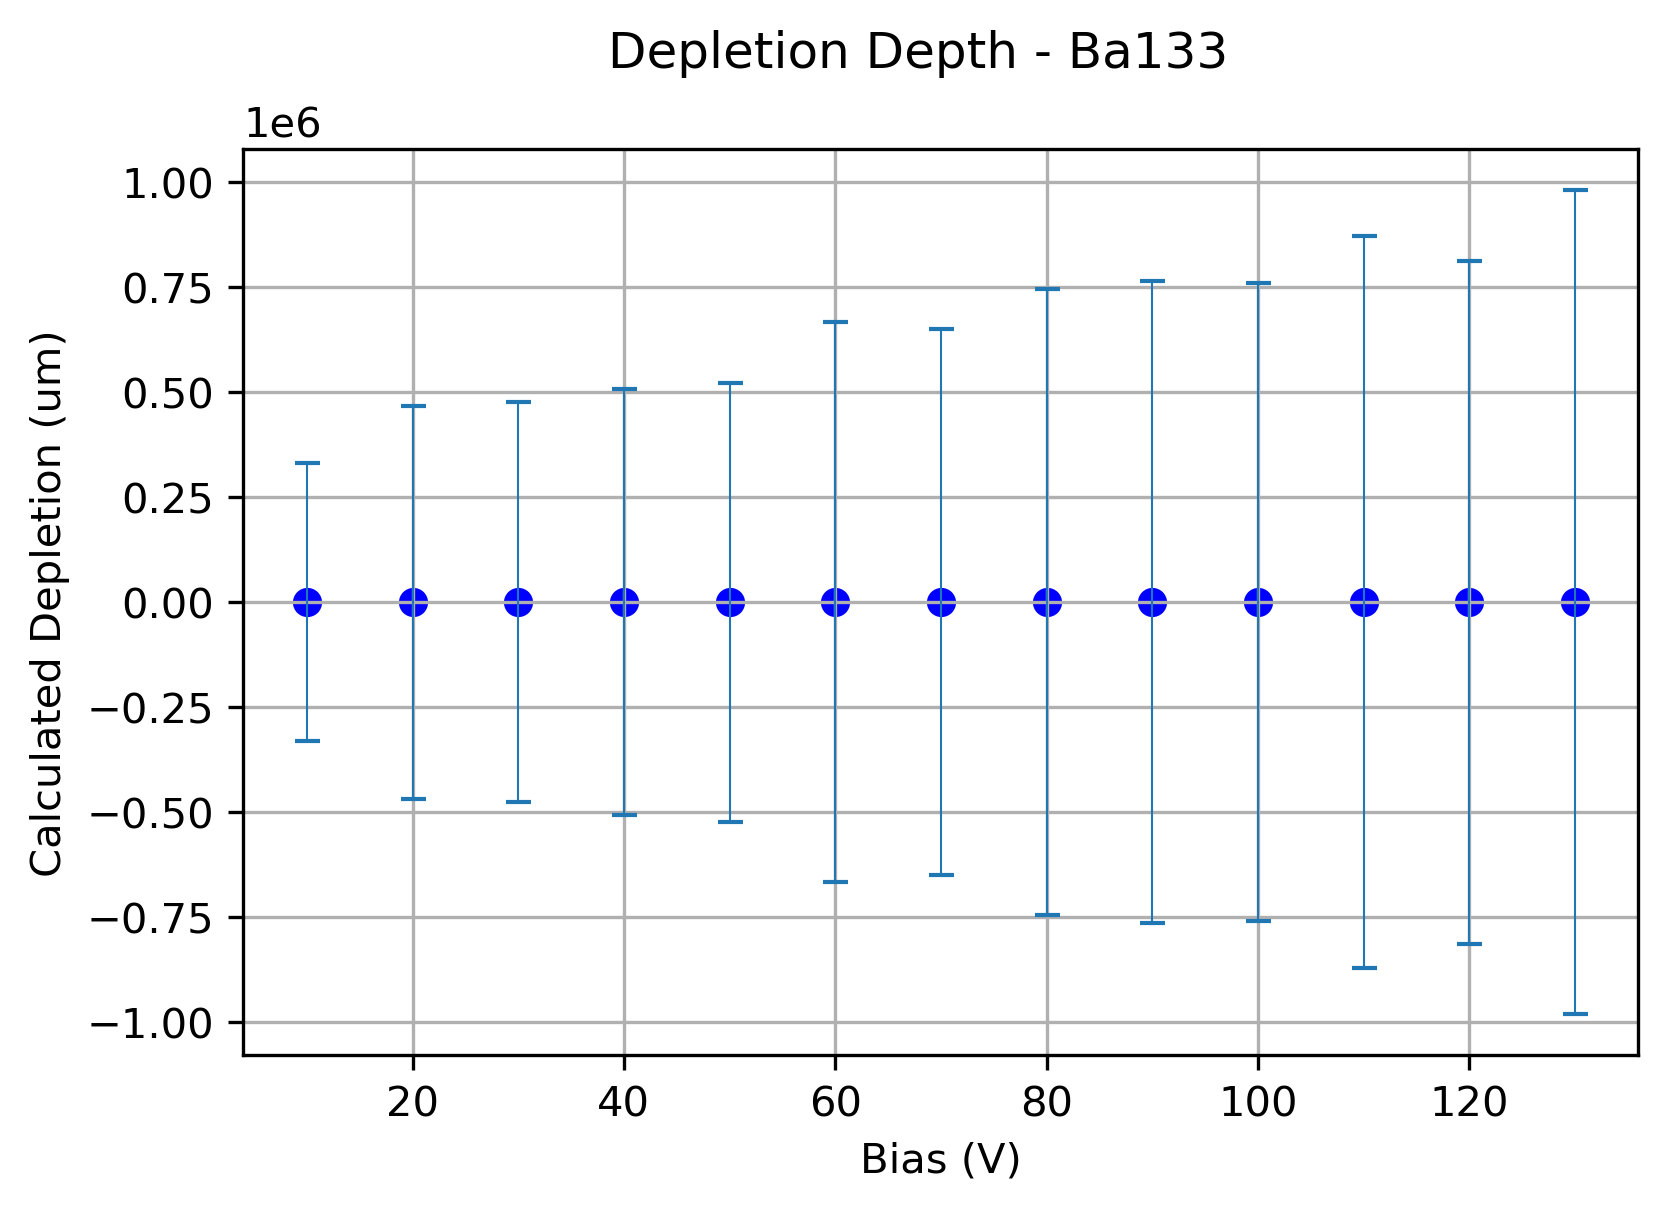

In [19]:
# This is just a plot of depletion with error bars
fig, ax = plt.subplots()
fig.suptitle("Depletion Depth - Ba133")
fig.set_dpi(150)

ax.errorbar(depletion.bias, depletion['depth(um)'], yerr=depletion.uncertianty, capsize=3, linewidth = .5, fmt='none')
ax.scatter(depletion.bias, depletion['depth(um)'], color = 'blue', label="Measured Depth")
ax.grid()
ax.set_xlabel("Bias (V)")
ax.set_ylabel("Calculated Depletion (um)")

fig.savefig(imgdir+"/"+extrapath+"depthVbias.png", facecolor='white')

## Power supply data

This graphs all of the currents logged while running the source scan. This section was never fully finished and could be done better by a modified version of `leakage.ipynb`


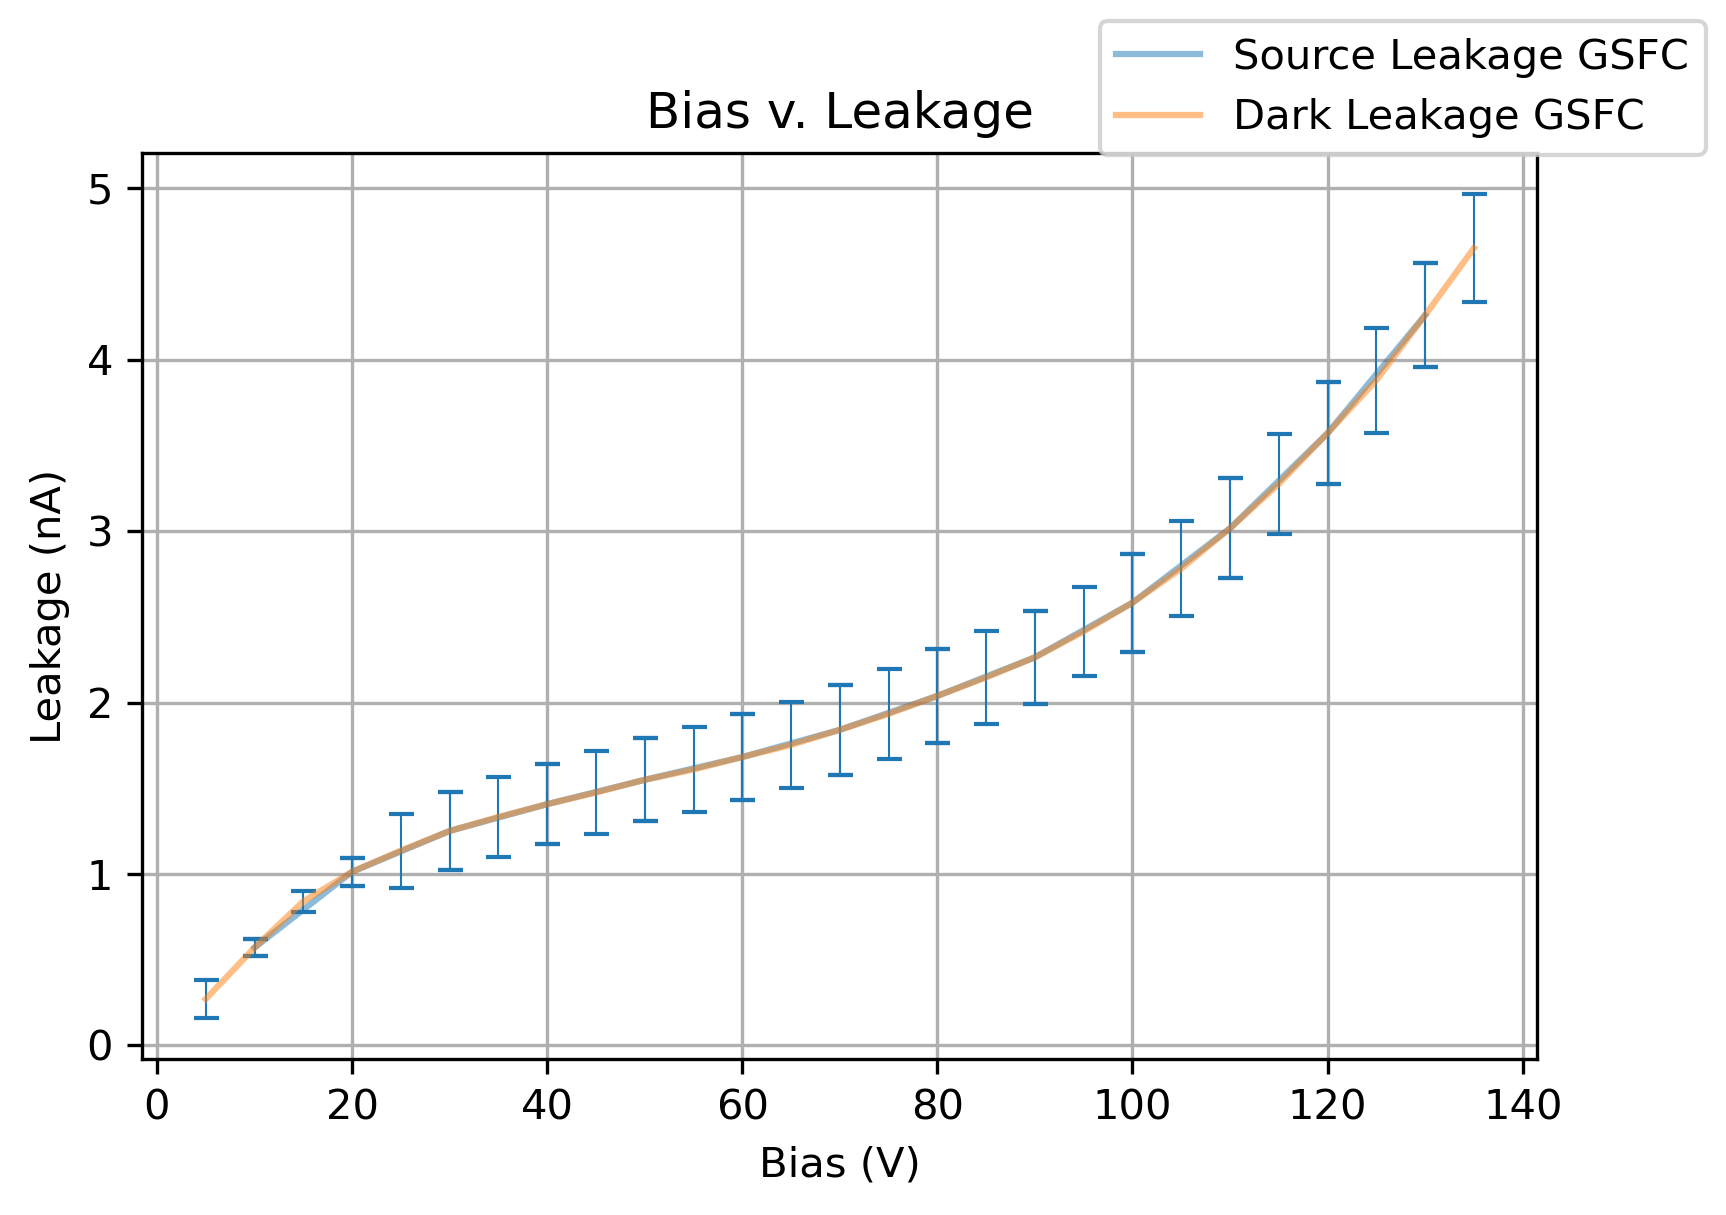

In [20]:
rundir = '7-14_run1/'
ydat = 'leakage_yasuke.csv'
adat = 'HVScan_-10_-135_-5step.csv'
adark = "HVScan_light_-10_-130_-10step-220714_093138.csv"
asrc = "megarun/HVScan3days.csv"
dfy = pd.read_csv(rundir+ydat)
dfa = pd.read_csv(rundir+adat)
dfa = dfa.abs()
dfdark = pd.read_csv(rundir+ adark).abs()
dfsr = pd.read_csv(asrc).abs()


def psData(dfb):
    by_voltage = []
    eqtime=180
    leakchop = []
    leakmin = []
    leakmax = []
    leakavg = []
    for i, volt in enumerate(dfb.VOLTAGE.unique()):
        by_voltage.append(dfa[dfa.VOLTAGE == volt])
        leakmin.append([by_voltage[i].READ.min(), volt, np.std(by_voltage[i].READ)])
        leakmax.append([by_voltage[i].READ.max(), volt, np.std(by_voltage[i].READ)])
        leakavg.append([by_voltage[i].READ.mean(), volt, np.std(by_voltage[i].READ)])
        leakchop.append([by_voltage[i][by_voltage[i].REL > eqtime].READ.mean(), volt, np.std(by_voltage[i][by_voltage[i].REL > eqtime].READ)])
    leakmin = np.array(leakmin)
    leakmax = np.array(leakmax)
    leakavg = np.array(leakavg)
    leakchop = np.array(leakchop)
    return (leakmin, leakmax, leakavg, leakchop)
 
leakdark = psData(dfa)[3]
leaklight = psData(dfdark)[3]
leaksrc = psData(dfsr)[3]

fig, ax = plt.subplots()
fig.set_dpi(150)
ax.set_title("Bias v. Leakage")
ax.set_xlabel("Bias (V)")
ax.set_ylabel("Leakage (nA)")
#ax.plot(dfy.VOLTAGE, dfy.READ* 10**9, label="Yasuke Leakage")

ax.errorbar(leaksrc[:,1], leaksrc[:,0] * 10**9, yerr=leaksrc[:,2]*10**9, fmt='none', capsize=3, linewidth = .5)
ax.plot(leaksrc[:,1], leaksrc[:,0]* 10**9, label="Source Leakage GSFC", alpha = .5)

ax.errorbar(leakdark[:,1], leakdark[:,0] * 10**9, yerr=leakdark[:,2]*10**9, fmt='none', capsize=3, linewidth = .5)
ax.plot(leakdark[:,1], leakdark[:,0]* 10**9, label="Dark Leakage GSFC", alpha=.5)

#ax.errorbar(leaklight[:,1], leaklight[:,0] * 10**9, yerr=leaklight[:,2]*10**9, fmt='none', capsize=3, linewidth = .5)
#ax.plot(leaklight[:,1], leaklight[:,0]* 10**9, label="Light Leakage GSFC")

ax.grid()
fig.legend()



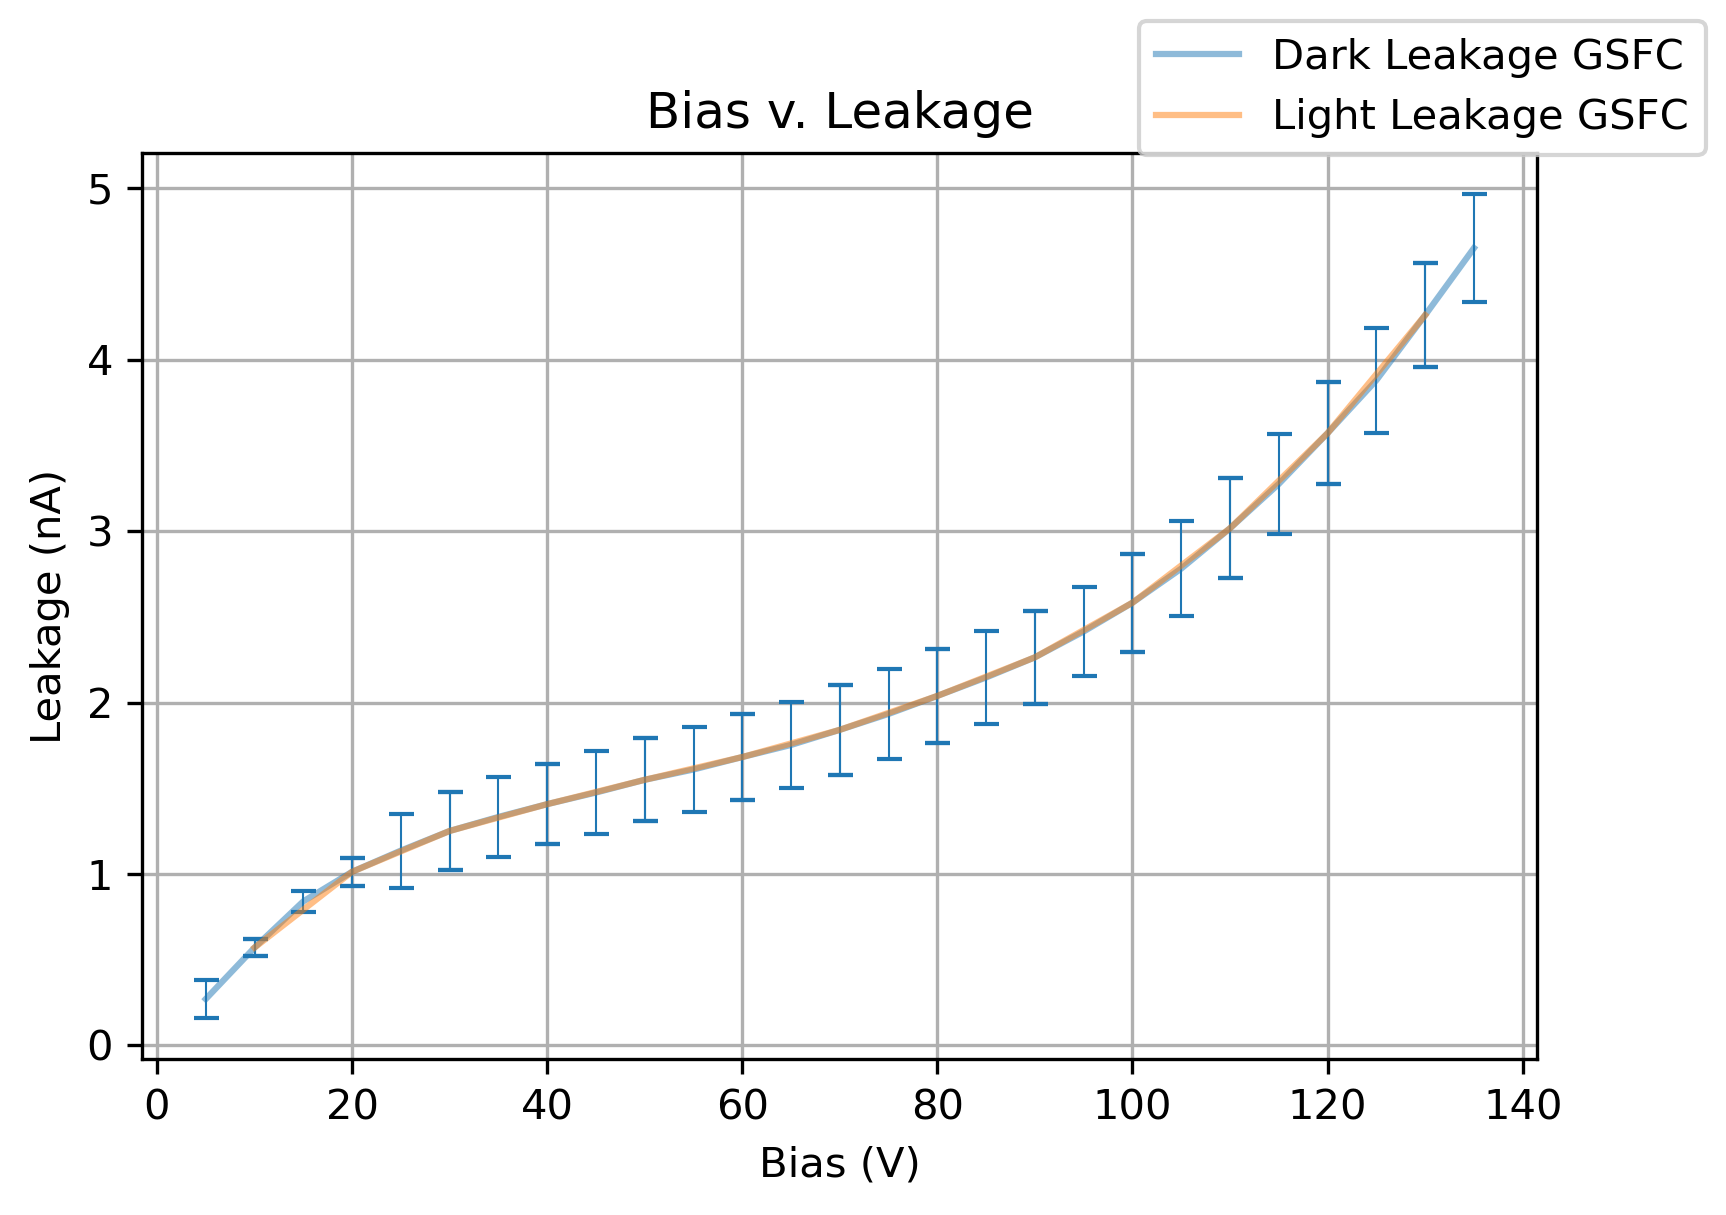

In [21]:
fig, ax = plt.subplots()
fig.set_dpi(150)
ax.set_title("Bias v. Leakage")
ax.set_xlabel("Bias (V)")
ax.set_ylabel("Leakage (nA)")
ax.errorbar(leakdark[:,1], leakdark[:,0] * 10**9, yerr=leakdark[:,2]*10**9, fmt='none', capsize=3, linewidth = .5)
ax.plot(leakdark[:,1], leakdark[:,0]* 10**9, label="Dark Leakage GSFC", alpha=.5)

ax.errorbar(leaklight[:,1], leaklight[:,0] * 10**9, yerr=leaklight[:,2]*10**9, fmt='none', capsize=3, linewidth = .5)
ax.plot(leaklight[:,1], leaklight[:,0]* 10**9, label="Light Leakage GSFC", alpha=.5)

ax.grid()
fig.legend()

In [22]:
psdir = datadir + "/ps/"
absval=True
psdf = pd.DataFrame(columns=["","REL","SEC","FRAC",'SOUR','SOURSTAT','STAT','READ','VOLTAGE'])
for path in os.listdir(psdir):
    if os.path.isdir(path): continue
    elif path.rfind(".csv") == -1: continue
    else:
        df = pd.read_csv(psdir+path)
        if absval:
            df = df.abs()
        psdf = pd.concat([psdf, df])
        
df = psdf.copy() 


In [24]:
df["TIME"] = df.SEC + df.FRAC
df = df.sort_values(by="TIME", axis=0, ascending=True).reset_index()
print(f"Datafile: {psdir}\n\
Contains {len(df.TIME)} entries. Run duration {(df.TIME.max()-df.TIME.min())/60:.4f}m.\n\
Voltage range: {df.VOLTAGE.min()}v to {df.VOLTAGE.max()}v")

Datafile: ./sourceScan//ps/
Contains 4001256 entries. Run duration 4679.9088m.
Voltage range: 10v to 130v


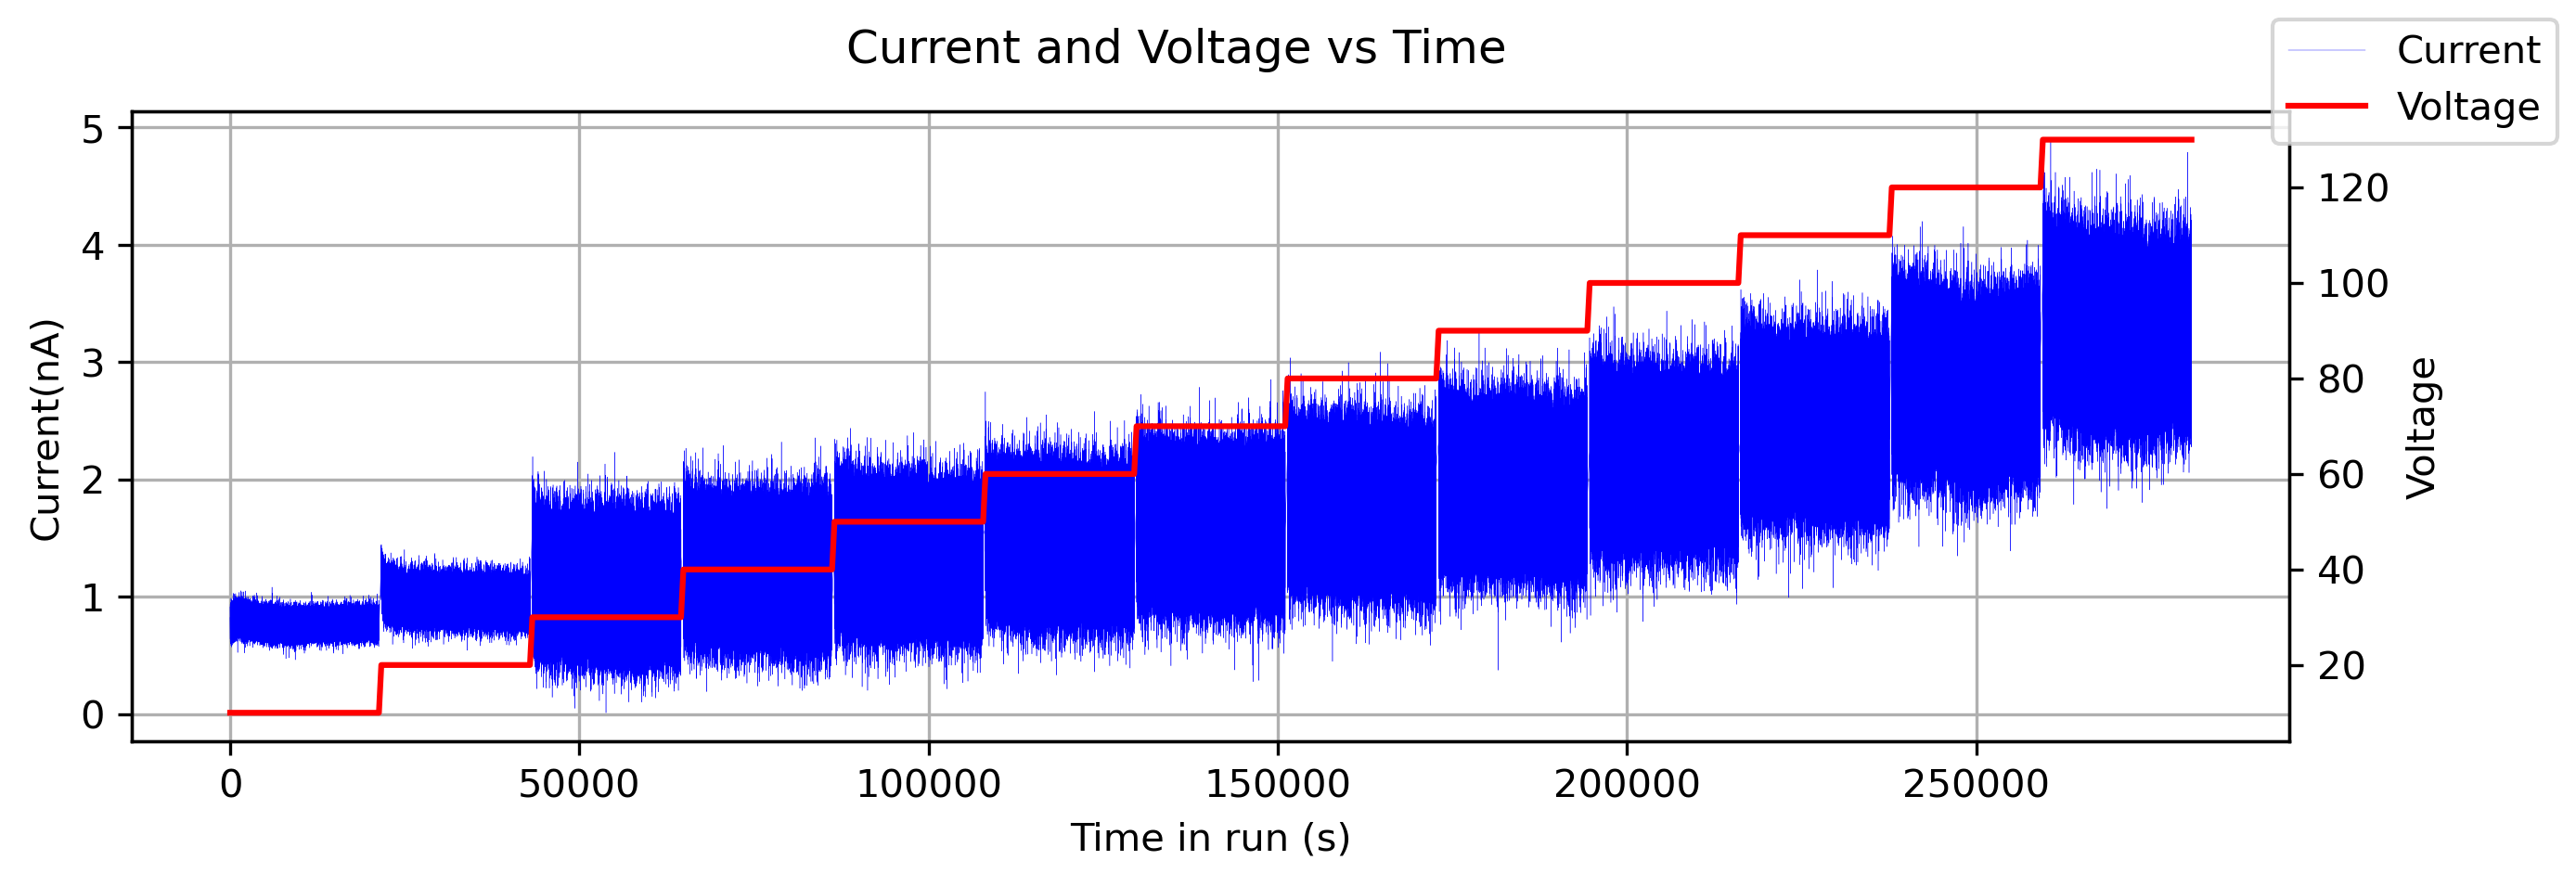

In [25]:
t_0 = df.TIME.loc[0]
fig, ax = plt.subplots()
fig.set_size_inches(10, 3)
fig.suptitle("Current and Voltage vs Time")
fig.set_dpi(150)
ax.plot(df.TIME-t_0, df.READ*10**9, color = 'blue', label="Current", linewidth=.1)
ax.set_xlabel("Time in run (s)")
ax.set_ylabel("Current(nA)")
ax.grid()
ax2 = ax.twinx()
ax2.plot(df.TIME - t_0, df.VOLTAGE, color = 'red', label="Voltage")
ax2.set_ylabel("Voltage")
fig.legend()
fig.savefig(imgdir+ "HVScanBa133-CvT_VvT.png", facecolor="white", dpi=600)
plt.show()

### Looking at analog data!

This is where I look at analog data from some of the runs so I can compare the signal rates between them. This will be more helpful when we start investegating the analog hitrates. Based on my inital  analysis it looks as though the digital hitrates are overall 10% lower than analog while the calculated signal rates are about 50% lower with a much higher background rate

In [30]:
# These are slightly modified versions of the functions above to make them work with the different data formats used before we rewrote astropix's codebase
def fitCurveA(hist:np.ndarray, bins:np.ndarray, time:float, imgpath:str, bias, rate, plot = True):
    """
    This is similar to the above, slightly diffrent in its inital guesses to make it more robust.
    """
    histTest = hist/time
    print(sum(histTest))
    
    sig = (np.sqrt(hist)/time)+1/time
    
    coef, pcov = optimize.curve_fit(gauss, bins, histTest,sigma=sig, absolute_sigma=True, p0=(sum(histTest)*2, bins[histTest == histTest.max()], 1, 0), bounds=(0, [np.inf, np.inf, np.inf, histTest.min()*2+1]))
    if plot:
        fig, ax = plt.subplots()
        fig.set_dpi(150)
        fig.set_size_inches((6, 4))
        if rate:
            ax.set_title("Analog ToT Ratehistogram\nBa133 6hr run " + str(bias) + "V bias")
            ax.set_ylabel("Counts per Minute")
        else:
            ax.set_title("Analog ToT Histogram\nBa133 6hr run " + str(bias) + "V bias")
            ax.set_ylabel("Counts")
        ax.set_xlabel("ToT(us)")
        ax.bar(bins, (histTest))
        ax.plot(bins, gauss(bins, *coef), color='red')
        fig.savefig(imgpath, dpi=200, facecolor='white')
        plt.close()
    perr = np.sqrt(np.diag(pcov))
    return ([*coef], [*perr])

def processDigital2(a):
    """
    Similar to above but has more returns
    returns: 
    (df, [counts_pre, counts_post])
    """
    len1 = len(a)
    a = a[(((a.Payload == ' 4') | (a.Payload == 4)) & ((a["ChipId"] == 0) | (a["ChipId"] == '0')))]
    len2 =len(a)
    group = a.groupby(["NEvent", "tStamp"])
    b = a.set_index(["NEvent", "tStamp"])
    counts = group.count().Payload
    counts = counts[counts==2]
    i = counts.index
    b = b.loc[i]
    col = b[b["Row/Col"] == "Col"]
    row = b[b["Row/Col"] == "Row"]
    return (b, [len1, len1-len2, len2], len(col), len(row))

Diff. Col-Row: 0

Ba133
Analog Rate: 9.9500
Digital Rate: 8.9111
%dffrence: 10.4411

8.911111111111111

Hit rate diffrence: 48.7685%
Analog signal: 6.3556 cpm
Digital signal: 3.2560 cpm
Digital Background: 5.5942 cpm
Analog Background: 3.5944 cpm


/Users/sbauman5/anaconda3/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


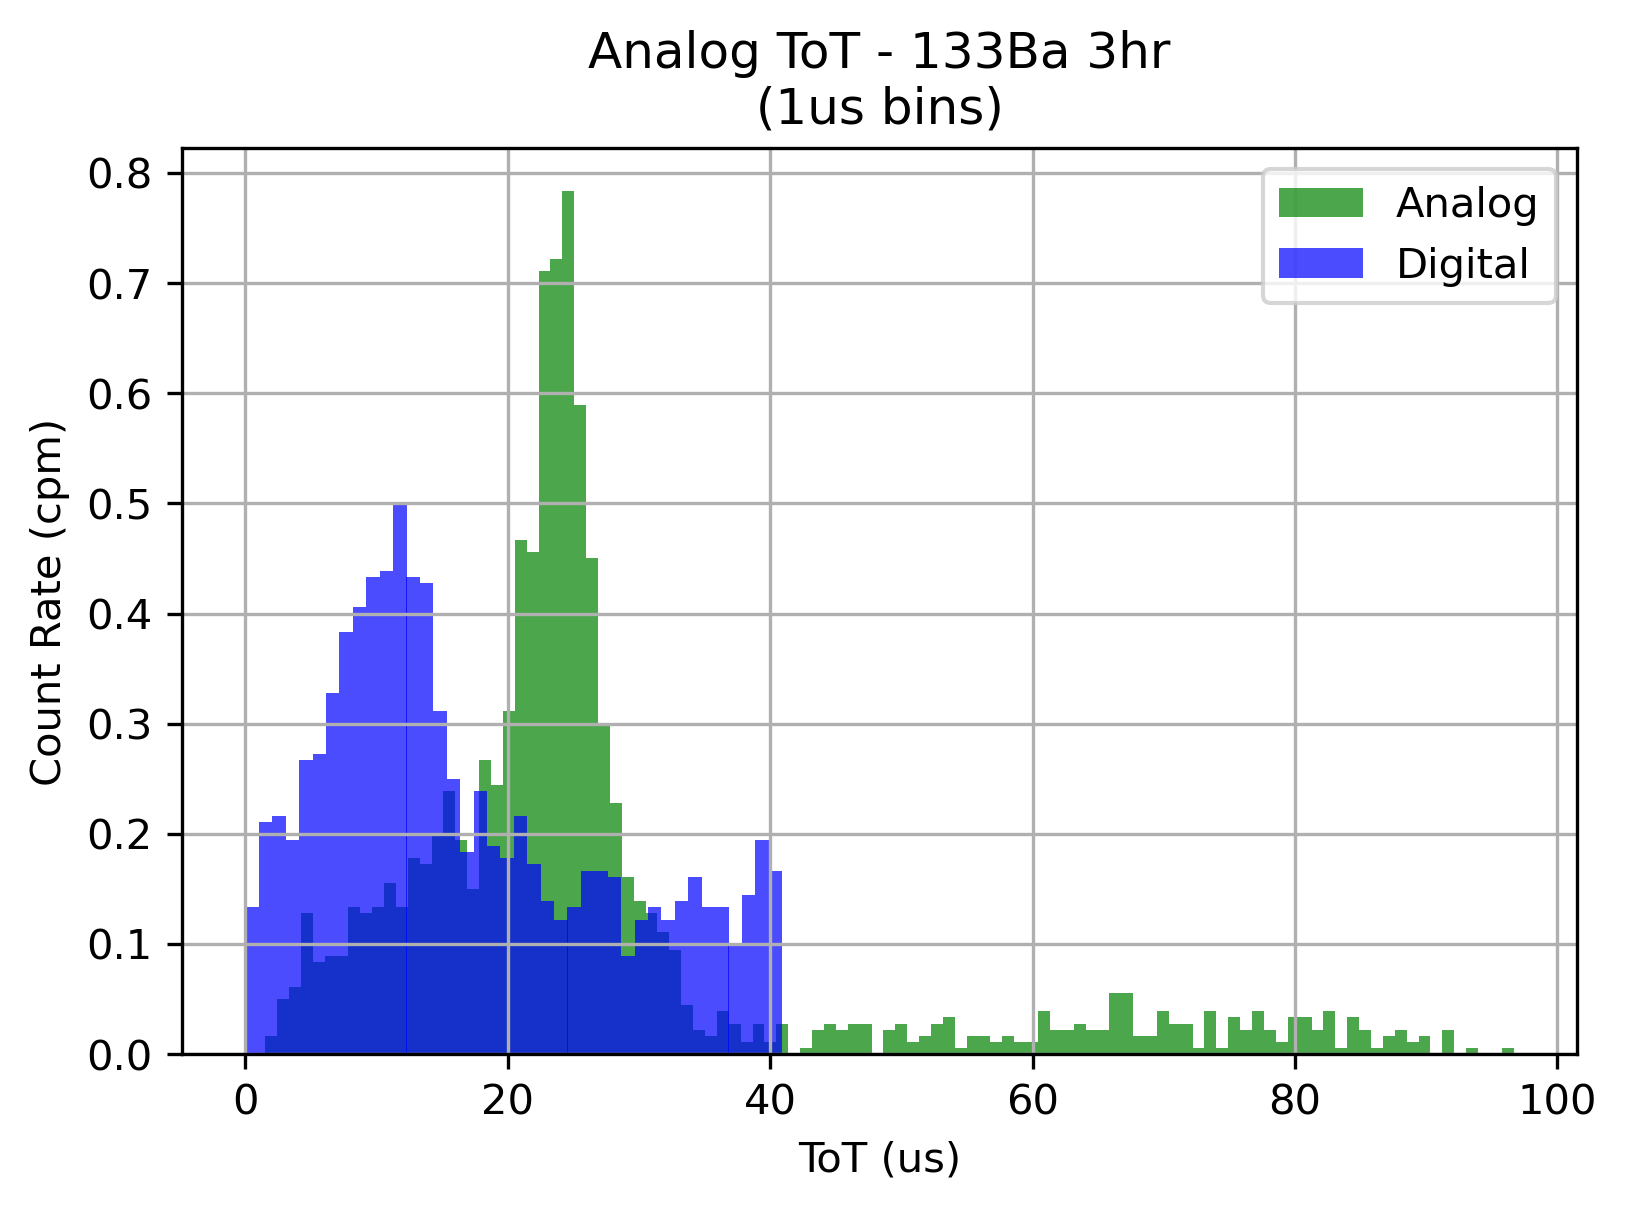

In [28]:
# Analog Data 
ana = "BariumData/chip602_DigitalPaired-0_Barium-133_180min.h5py"
# Digital Data 
dig = "BariumData/chip602_Barium-133_180min_pix00_100mV_beamDigital_20220713-101351.csv"

bias = 60

analog = h5py.File(ana, 'r')
b = np.array(analog.get('run1_analogToT'))
D = pd.read_csv(dig)

runtime=180 # runtime in minutes

# Analog ToT range which contains the peak
a_min = 17
a_max = 35

peak = len(b[((b > a_min) & (b < a_max))])/runtime

df, counts, lencol, lenrow = processDigital2(D)
print(f"Diff. Col-Row: {lencol-lenrow}")

analog_rate = len(b)/runtime
digit_rate = lencol/runtime
print(f"\nBa133\nAnalog Rate: {analog_rate:0.4f}\nDigital Rate: {digit_rate:0.4f}\n%dffrence: {100* (analog_rate-digit_rate)/analog_rate:0.4f}\n")

fig, ax = plt.subplots()
fig.set_dpi(150)

# Analog bins
nbins1 = 105
# Digital bins
nbins2 = 40


### DIGITAL
binsize1 = (df["ToT(us)"].max()-df["ToT(us)"].min())/nbins2
hist1, bins1 = np.histogram(df[df["Row/Col"]=="Row"]["ToT(us)"], bins = nbins2)
bincenter1 = (bins1 + (binsize1/2))[0:-1]

coefs_d, perr_d = fitCurveA(hist1, bincenter1, runtime, f"blahVbias.png", bias, False, False)

### ANALOG

binsize2 = (b.max()-b.min())/nbins1
hist2, bins2 = np.histogram(b, bins = nbins1)
bincenter2 = (bins2 + (binsize2/2))[0:-1]

ax.bar(bincenter2, hist2/runtime, width=binsize2, color='green', alpha=.7, label="Analog")
ax.bar(bincenter1, hist1/runtime, width=binsize1, color='blue', alpha=.7, label="Digital")


# For plotting the digital fit
x = np.linspace(0,50, 200)

ax.grid()
ax.set_title('Analog ToT - 133Ba 3hr\n(1us bins)')
ax.set_ylabel('Count Rate (cpm)')
ax.set_xlabel('ToT (us)')

#plt.plot(x, gauss(x, *coefs_d), color='red')
ax.legend()
#print(coefs_d, perr_d, "\n")

print(f"\nHit rate diffrence: {((peak-coefs_d[0])/peak)*100:0.4f}%\nAnalog signal: {peak:0.4f} cpm\nDigital signal: {coefs_d[0]:0.4f} cpm\nDigital Background: {coefs_d[-1]*nbins2:0.4f} cpm\nAnalog Background: {(len(b)/runtime)-peak:0.4f} cpm")
plt.show()


Diff. Col-Row: -4

Am241
Analog Rate: 18.33888888888889
Digital Rate: 16.511111111111113
%dffrence: 9.966676764616771

16.53333333333333


/Users/sbauman5/anaconda3/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)



Hit rate diffrence: 53.6178%
Analog signal: 15.0444 cpm
Digital signal: 6.9779 cpm
Digital Background: 9.3260 cpm
Analog Background: 3.2944 cpm


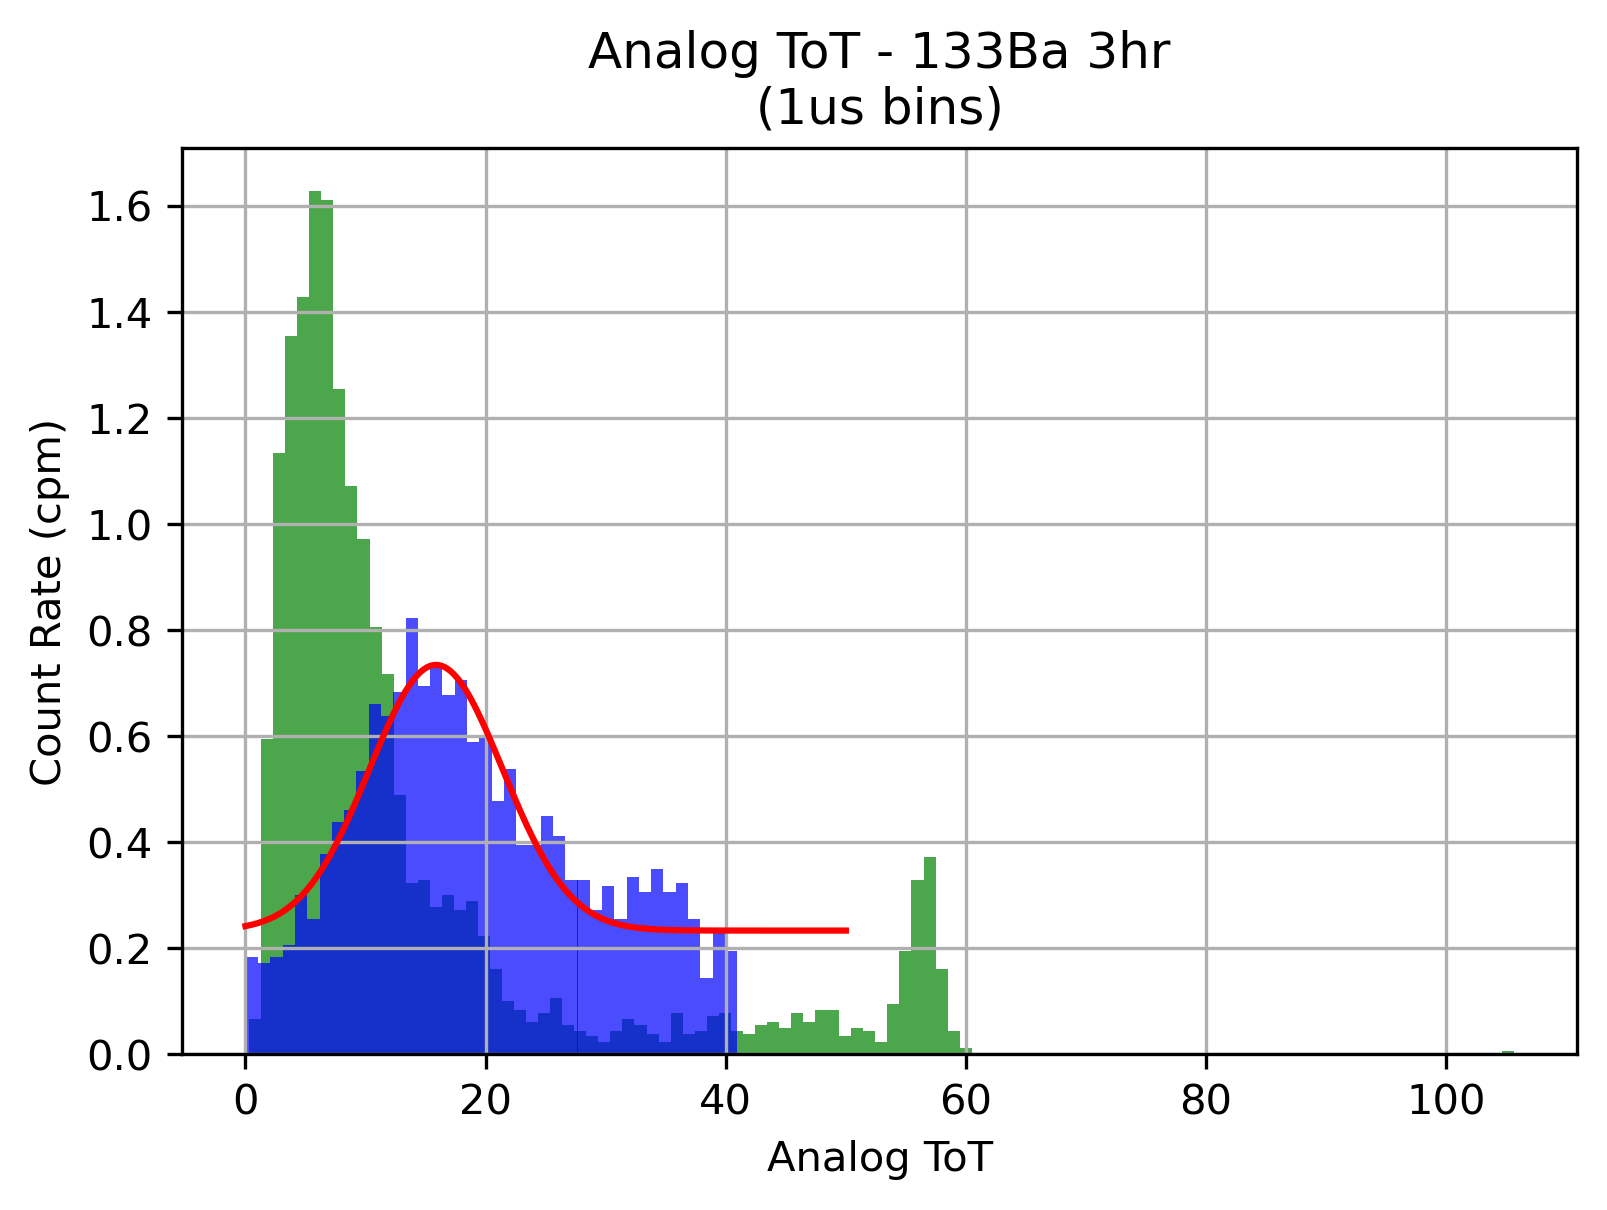

In [29]:
# Am 241 Hitrate comparison 
# Analog path
ana = "AvD/chip602_DigitalPaired-0_Americium-241_90min.h5py"
# Digital path
dig = "AvD/chip602_Americium-241_90min_pix00_100mV_beamDigital_20220713-134207.csv"

bias = 60

analog = h5py.File(ana, 'r')
b = np.array(analog.get('run1_analogToT'))
D = pd.read_csv(dig)

runtime=180 # runtime in minutes

# Analog ToT range which contains the peak
a_min = 0
a_max = 20

peak = len(b[((b > a_min) & (b < a_max))])/runtime

df, counts, lencol, lenrow = processDigital2(D)
print(f"Diff. Col-Row: {lencol-lenrow}")

analog_rate = len(b)/runtime
digit_rate = lencol/runtime
print(f"\nAm241\nAnalog Rate: {analog_rate}\nDigital Rate: {digit_rate}\n%dffrence: {100* (analog_rate-digit_rate)/analog_rate}\n")

fig, ax = plt.subplots()
fig.set_dpi(150)

# Analog bins
nbins1 = 105
# Digital bins
nbins2 = 40


### DIGITAL
binsize1 = (df["ToT(us)"].max()-df["ToT(us)"].min())/nbins2
hist1, bins1 = np.histogram(df[df["Row/Col"]=="Row"]["ToT(us)"], bins = nbins2)
bincenter1 = (bins1 + (binsize1/2))[0:-1]

coefs_d, perr_d = fitCurveA(hist1, bincenter1, runtime, f"blahVbias.png", bias, False)

### ANALOG

binsize2 = (b.max()-b.min())/nbins1
hist2, bins2 = np.histogram(b, bins = nbins1)
bincenter2 = (bins2 + (binsize2/2))[0:-1]

ax.bar(bincenter2, hist2/runtime, width=binsize2, color='green', alpha=.7, label="Analog")
ax.bar(bincenter1, hist1/runtime, width=binsize1, color='blue', alpha=.7, label="Digital")


# For plotting the digital fit
x = np.linspace(0,50, 200)

ax.grid()
ax.set_title('Analog ToT - 133Ba 3hr\n(1us bins)')
ax.set_ylabel('Count Rate (cpm)')
ax.set_xlabel('Analog ToT')

plt.plot(x, gauss(x, *coefs_d), color='red')

#print(coefs_d, perr_d, "\n")

print(f"\nHit rate diffrence: {((peak-coefs_d[0])/peak)*100:0.4f}%\nAnalog signal: {peak:0.4f} cpm\nDigital signal: {coefs_d[0]:0.4f} cpm\nDigital Background: {coefs_d[-1]*nbins2:0.4f} cpm\nAnalog Background: {(len(b)/runtime)-peak:0.4f} cpm")
plt.show()
